**Reference**: ["Fast Conditional Independence Test for Vector Variables with Large Sample Sizes"](https://arxiv.org/abs/1804.02747); Krzysztof Chalupka, Pietro Perona, Frederick Eberhardt (2018)

In [31]:
import pandas as pd
import numpy as np
from fcit import fcit
from CCIT import DataGen
from aif360.datasets import AdultDataset
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_roc_curve, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector

## Generated Dataset

In [8]:
dx = 1
dy = 5
dz = 1

### Not independent

In [10]:
# not independent
data = DataGen.generate_samples_cos(dx=dx, dy=dy, dz=dz, sType='NI')

X = data[:,:dx]
Y = data[:,dx:dx+dy]
Z = data[:,dx+dy:dx+dy+dz]

p_value = fcit.test(X, Y, Z)
print(f"p-value: {p_value}")

p-value: 0.0005019075344327932


### Conditionally independent

In [11]:
# conditionally independent
data = DataGen.generate_samples_cos(dx=dx, dy=dy, dz=dz, sType='CI')

X = data[:,:dx]
Y = data[:,dx:dx+dy]
Z = data[:,dx+dy:dx+dy+dz]

p_value = fcit.test(X, Y, Z)
print(f"p-value: {p_value}")

p-value: 0.858884199155878


### Independent

In [18]:
# independent
data = DataGen.generate_samples_cos(dx=dx, dy=dy, dz=dz, sType='I')

X = data[:,:dx]
Y = data[:,dx:dx+dy]
Z = data[:,dx+dy:dx+dy+dz]

p_value = fcit.test(X, Y, )
print(f"p-value: {p_value}")

p-value: 0.266353720848029


## Real life Dataset

In [20]:
data, _metadata = AdultDataset().convert_to_dataframe(de_dummy_code=True, set_category=True)
data.head()

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,income-per-year,workclass,education,marital-status,occupation,relationship,native-country
0,39.0,13.0,White,Male,2174.0,0.0,40.0,<=50K,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,United-States
1,50.0,13.0,White,Male,0.0,0.0,13.0,<=50K,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,United-States
2,38.0,9.0,White,Male,0.0,0.0,40.0,<=50K,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,United-States
3,53.0,7.0,Non-white,Male,0.0,0.0,40.0,<=50K,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,United-States
4,28.0,13.0,Non-white,Female,0.0,0.0,40.0,<=50K,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Cuba


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 14 columns):
age                45222 non-null float64
education-num      45222 non-null float64
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
income-per-year    45222 non-null object
workclass          45222 non-null category
education          45222 non-null category
marital-status     45222 non-null category
occupation         45222 non-null category
relationship       45222 non-null category
native-country     45222 non-null category
dtypes: category(6), float64(5), object(3)
memory usage: 3.4+ MB


### Data Transformation

In [22]:
numeric_columns = make_column_selector(dtype_exclude=["category", "object"])(data)
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_columns = make_column_selector(dtype_include=["category", "object"])(data)
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', ))
    ]
)

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

np_trasformed = preprocessor.fit_transform(data).todense()

cols = []
cols += numeric_columns
cols += preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names(categorical_columns).tolist()

df_transformed = pd.DataFrame(np_trasformed, columns=cols, index=data.index)
df_transformed.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,race_White,sex_Male,income-per-year_>50K,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.034201,1.128753,0.142888,-0.21878,-0.078120,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.866417,1.128753,-0.146733,-0.21878,-2.326738,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.041455,-0.438122,-0.146733,-0.21878,-0.078120,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.093385,-1.221559,-0.146733,-0.21878,-0.078120,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.798015,1.128753,-0.146733,-0.21878,-0.078120,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Regression

### Model building

In [24]:
model = XGBRegressor()

y = df_transformed["capital-gain"].values
X = df_transformed.drop(columns=["capital-gain"]).values

model.fit(X, y)

y_hat = model.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_hat))
print("RMSE: %f" % (rmse))

/usr/local/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[13:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.927005


### Bias test

In [25]:
from functools import reduce

columns_selectors = [
    make_column_selector("^age")
]
protected_columns = reduce(lambda s, e: s + e(df_transformed), columns_selectors, [])

Z = df_transformed[protected_columns].values

Y_hat = y_hat.reshape(-1, 1)
Y = y.reshape(-1, 1)

#### Equalized odds - test

In [28]:
pvalue = fcit.test(Y_hat, Z, Y, num_perm=20)
print("p-value", pvalue)

p-value 5.182983651105436e-28


We have $p \leq 0.05$, which implies that we can reject $H_0: \hat{Y} \perp \!\!\! \perp Z|Y$. The model does not satisfy the Equality of odds fairness metric.

#### Demographic parity - test

In [27]:
pvalue = fcit.test(Y_hat, Z)
print("p-value", pvalue)

p-value 1.4083554385509077e-13


We have $p \leq 0.05$, which implies that we can reject $H_0: \hat{Y} \perp \!\!\! \perp Z$. The model does not satisfy Demographic parity fairness metric.

## Classification

### Model building

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     34014
         1.0       0.80      0.60      0.68     11208

    accuracy                           0.86     45222
   macro avg       0.84      0.77      0.80     45222
weighted avg       0.86      0.86      0.86     45222



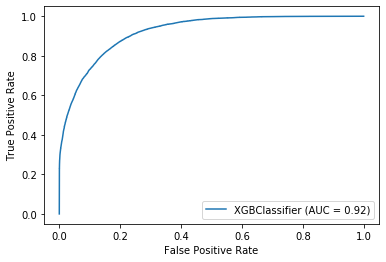

In [32]:
model = XGBClassifier()

y = df_transformed["income-per-year_>50K"].values
X = df_transformed.drop(columns=["income-per-year_>50K"]).values

model.fit(X, y)

y_hat = model.predict(X)

print(classification_report(y, y_hat))

plot_roc_curve(model, X, y)

### Bias test

In [34]:
from functools import reduce

columns_selectors = [
    make_column_selector("^age"),
    make_column_selector("^race"),
    make_column_selector("^native-country")
]
protected_columns = reduce(lambda s, e: s + e(df_transformed), columns_selectors, [])

Z = df_transformed[protected_columns].values

Y_hat = y_hat.reshape(-1, 1)
Y = y.reshape(-1, 1)

#### Equalized odds - test

In [36]:
pvalue = fcit.test(Y_hat, Z, Y)
print("p-value", pvalue)

p-value 8.882495950202016e-06


We have $p \leq 0.05$, which implies that we can reject $H_0: \hat{Y} \perp \!\!\! \perp Z|Y$. The model does not satisfy the Equality of odds fairness metric.

#### Demographic parity - test

In [37]:
pvalue = fcit.test(Y_hat, Z)
print("p-value", pvalue)

p-value 4.1535776956902023e-10


We have $p \leq 0.05$, which implies that we can reject $H_0: \hat{Y} \perp \!\!\! \perp Z$. The model does not satisfy Demographic parity fairness metric.